# Item2Vec Recommender System

# Table of Contents
- [1. Background](#bg)
- [2. Import Package](#package)
- [3. Import Data](#data)
- [4. Data Preprocessing](#prep)
    - [4.1. Create Rated Movie List (Vector)](#prep_ratedmv)
    - [4.2. Train and Test Split](#prep_split)
- [5. Modeling](#model)
    - [5.1. Training](#model_train)
    - [5.2. Loss Evaluation](#model_loss)
    - [5.3. Vector Visualization](#model_viz)
- [6. Generate Recommendation](#generate)
    - [6.1. Show Recommendation for One User](#generate_example)
    - [6.2. Generate Recommendation for All Users](#generate_all)

# Background <a class='anchor' id='bg'></a>

We will create a content based filtering recommender system. In this case we use Word2Vec to find similarity between item. We pretend a list of rated item by each user as a text and the item in the list as a word.

Okay, so you might wonder what is Word2Vec actually? Developed by [Tomas Mikolov](https://arxiv.org/pdf/1310.4546.pdf) in 2013 at Google, it is one of the most common technique to do word embeddings in several Natural Language Processing (NLP) cases using shallow neural network. Word embeddings is just a fancy way of saying a numerical representation of words. A good analogy would be how colors are represented with a RGB values. These set of values is then called as a **vector**. For example, "black" can be associated with (0,0,0) and "white" with (255,255,255) as their pixel intensity values.

# Import Package <a class='anchor' id='package'></a>

we use <a href = 'https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py' target = '_blank'>gensim for Word2Vec</a> library

In [34]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

# Modeling
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.model_selection import train_test_split
from scipy import stats

# Additional
import math
import random
import itertools
import multiprocessing
from tqdm import tqdm
from time import time
import logging
import pickle

# Import Data <a class='anchor' id='data'></a>

We use Movie Recommender System Dataset from <a href = 'https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset' target = '_blank'>Kaggle</a>

In [2]:
data_mv = pd.read_csv('Data/movies.csv')
data_rating = pd.read_csv('Data/ratings.csv')

In [3]:
data_mv.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [6]:
data_rating.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


# Data Preprocessing <a class='anchor' id='prep'></a>

We will create list(vector) that contains all rated movie of each user and then we split the data into train and test (by user)

## Create Rated Movie List (Vector) <a class='anchor' id='prep_ratedmv'></a>

In [20]:
rated_mv_ls = data_rating.copy()

rated_mv_ls['movieId'] = rated_mv_ls['movieId'].astype(str) + "|"
rated_mv_ls = rated_mv_ls.groupby('userId').agg(movie_ls = ('movieId','sum')).reset_index()
rated_mv_ls['movie_ls'] = rated_mv_ls['movie_ls'].str[:-1]
rated_mv_ls['movie_ls'] = rated_mv_ls['movie_ls'].str.split("|")

In [29]:
rated_mv_ls.head(10)

,userId,movie_ls
0,1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
1,2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
2,3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,..."
3,4,"[21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1..."
4,5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."
5,6,"[2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, ..."
6,7,"[1, 50, 58, 150, 165, 260, 356, 380, 466, 480,..."
7,8,"[2, 10, 11, 21, 32, 34, 39, 47, 50, 110, 141, ..."
8,9,"[41, 187, 223, 371, 627, 922, 923, 1037, 1095,..."
9,10,"[296, 356, 588, 597, 912, 1028, 1088, 1247, 13..."


## Train and Test Split <a class='anchor' id='prep_split'></a>

In [31]:
ratedls_train, ratedls_test = train_test_split(rated_mv_ls, test_size = 0.1,
                                               shuffle = True, random_state = 42)

# Modeling <a class='anchor' id='model'></a>

We will create Word2Vec model to train our rated movie list of each user. After that, we will have a little analysis before continue to the next step.

In [35]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.training_loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            current_loss = loss
        else:
            current_loss = loss - self.loss_previous_step
        print(f"Loss after epoch {self.epoch}: {current_loss}")
        self.training_loss.append(current_loss)
        self.epoch += 1
        self.loss_previous_step = loss

## Training <a class='anchor' id='model_train'></a>

By using `gensim`, the training process can be separated into **three distinctive steps**: 

First, the instance of `Word2Vec()` is created to set up the parameters of the model and leave the model uninitialized.
- `size`: dimensionality of the song vectors
- `window`: maximum distance between context and target
- `min_count`: frequency cut-off for a song to be considered in the model
- `sg = 0`: using CBOW architecture
- `negative`: negative sampling data
- `workers`: number of CPU used to train the model

In [37]:
model = Word2Vec(
    vector_size = 256,
    window = 10,
    min_count = 1,
    sg = 0,
    negative = 20,
    workers = multiprocessing.cpu_count()-1)
print(model)

2022-06-24 16:47:47,677 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=256, alpha=0.025>', 'datetime': '2022-06-24T16:47:47.677891', 'gensim': '4.2.0', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.3.0-61-generic-x86_64-with-glibc2.27', 'event': 'created'}


Word2Vec<vocab=0, vector_size=256, alpha=0.025>


Secondly, the method `.build_vocab()` is called to build the vocabulary from a sequence of playlists and thus initialized the model.

In [38]:
logging.disable(logging.NOTSET) # enable logging
t = time()

model.build_vocab(ratedls_train['movie_ls'].values)

print(f"Time to build vocab: {round((time() - t), 2)} seconds")

2022-06-24 16:48:45,755 : INFO : collecting all words and their counts
2022-06-24 16:48:45,758 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-24 16:48:45,786 : INFO : collected 8964 word types from a corpus of 86650 raw words and 549 sentences
2022-06-24 16:48:45,787 : INFO : Creating a fresh vocabulary
2022-06-24 16:48:45,837 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 8964 unique words (100.00% of original 8964, drops 0)', 'datetime': '2022-06-24T16:48:45.837241', 'gensim': '4.2.0', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.3.0-61-generic-x86_64-with-glibc2.27', 'event': 'prepare_vocab'}
2022-06-24 16:48:45,838 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 86650 word corpus (100.00% of original 86650, drops 0)', 'datetime': '2022-06-24T16:48:45.838283', 'gensim': '4.2.0', 'python': '3.9.7 | packaged by conda-forge | (defau

Time to build vocab: 0.31 seconds


Finally, `.train()` trains the model. The loggings here are mainly useful for monitoring the loss after each epoch.
- `total_examples`: count of unique vocabulary (songs)
- `epochs`: number of iterations over the dataset (whole playlist)
- `compute_loss`: track model loss

In [39]:
logging.disable(logging.INFO) # disable logging
callback = Callback() # instead, print out loss for each epoch
t = time()

model.train(ratedls_train['movie_ls'].values,
            total_examples = model.corpus_count,
            epochs = 100,
            compute_loss = True,
            callbacks = [callback]) 

print(f"Time to train the model: {round((time() - t), 2)} seconds")

Loss after epoch 1: 62817.35546875
Loss after epoch 2: 36495.81640625
Loss after epoch 3: 32651.546875
Loss after epoch 4: 24894.921875
Loss after epoch 5: 21541.0625
Loss after epoch 6: 19856.953125
Loss after epoch 7: 20424.1875
Loss after epoch 8: 17887.328125
Loss after epoch 9: 17124.1875
Loss after epoch 10: 18005.984375
Loss after epoch 11: 16301.78125
Loss after epoch 12: 15572.1875
Loss after epoch 13: 16206.09375
Loss after epoch 14: 16243.6875
Loss after epoch 15: 16059.65625
Loss after epoch 16: 15818.4375
Loss after epoch 17: 13874.21875
Loss after epoch 18: 14830.28125
Loss after epoch 19: 14582.5
Loss after epoch 20: 14661.65625
Loss after epoch 21: 14357.34375
Loss after epoch 22: 14206.875
Loss after epoch 23: 13970.28125
Loss after epoch 24: 13666.59375
Loss after epoch 25: 12351.375
Loss after epoch 26: 14179.40625
Loss after epoch 27: 13287.9375
Loss after epoch 28: 12908.53125
Loss after epoch 29: 12629.8125
Loss after epoch 30: 12844.3125
Loss after epoch 31: 1246

In [40]:
print(model)

Word2Vec<vocab=8964, vector_size=256, alpha=0.025>


## Loss Evaluation <a class='anchor' id='model_loss'></a>

Plot the training loss, making sure it decreases after each epoch. The closer the loss to a zero value, the better the model is in predicting a target song given surrounding context songs. Thus, the produced song vectors are more meaningful.

In [41]:
logging.disable(logging.INFO) # disable logging

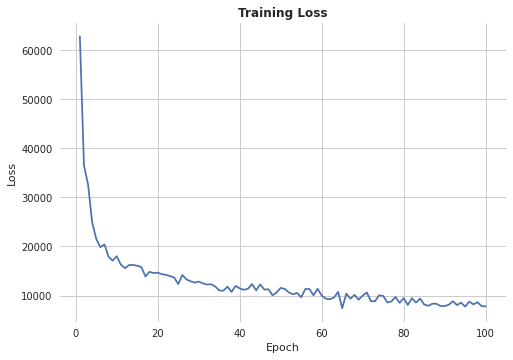

In [65]:
plt.plot(range(1, model.epochs+1), callback.training_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss", fontweight = "bold")
plt.show()

## Vectors Visualization <a class='anchor' id='model_viz'></a>

The movie vectors can be visualized using a gradient of colors. The model is trained using 256 dimensions, therefore there will be 256 color bars for each song, representing element values in the vector. The similarity between movies is calculated using **cosine similarity**:

$similarity(A,B) = cos(\theta) = \frac{A.B}{\|A\| \|B\|}$

Mathematically it measures the cosine of the angle between two vectors $A$ and $B$ which projected in a multi-dimensional space. movie vectors with similar context occupy close spatial positions; the cosine between such vectors should be close to 1, i.e. angle is closer to 0. The smaller the angle, the cosine similarity will be higher.

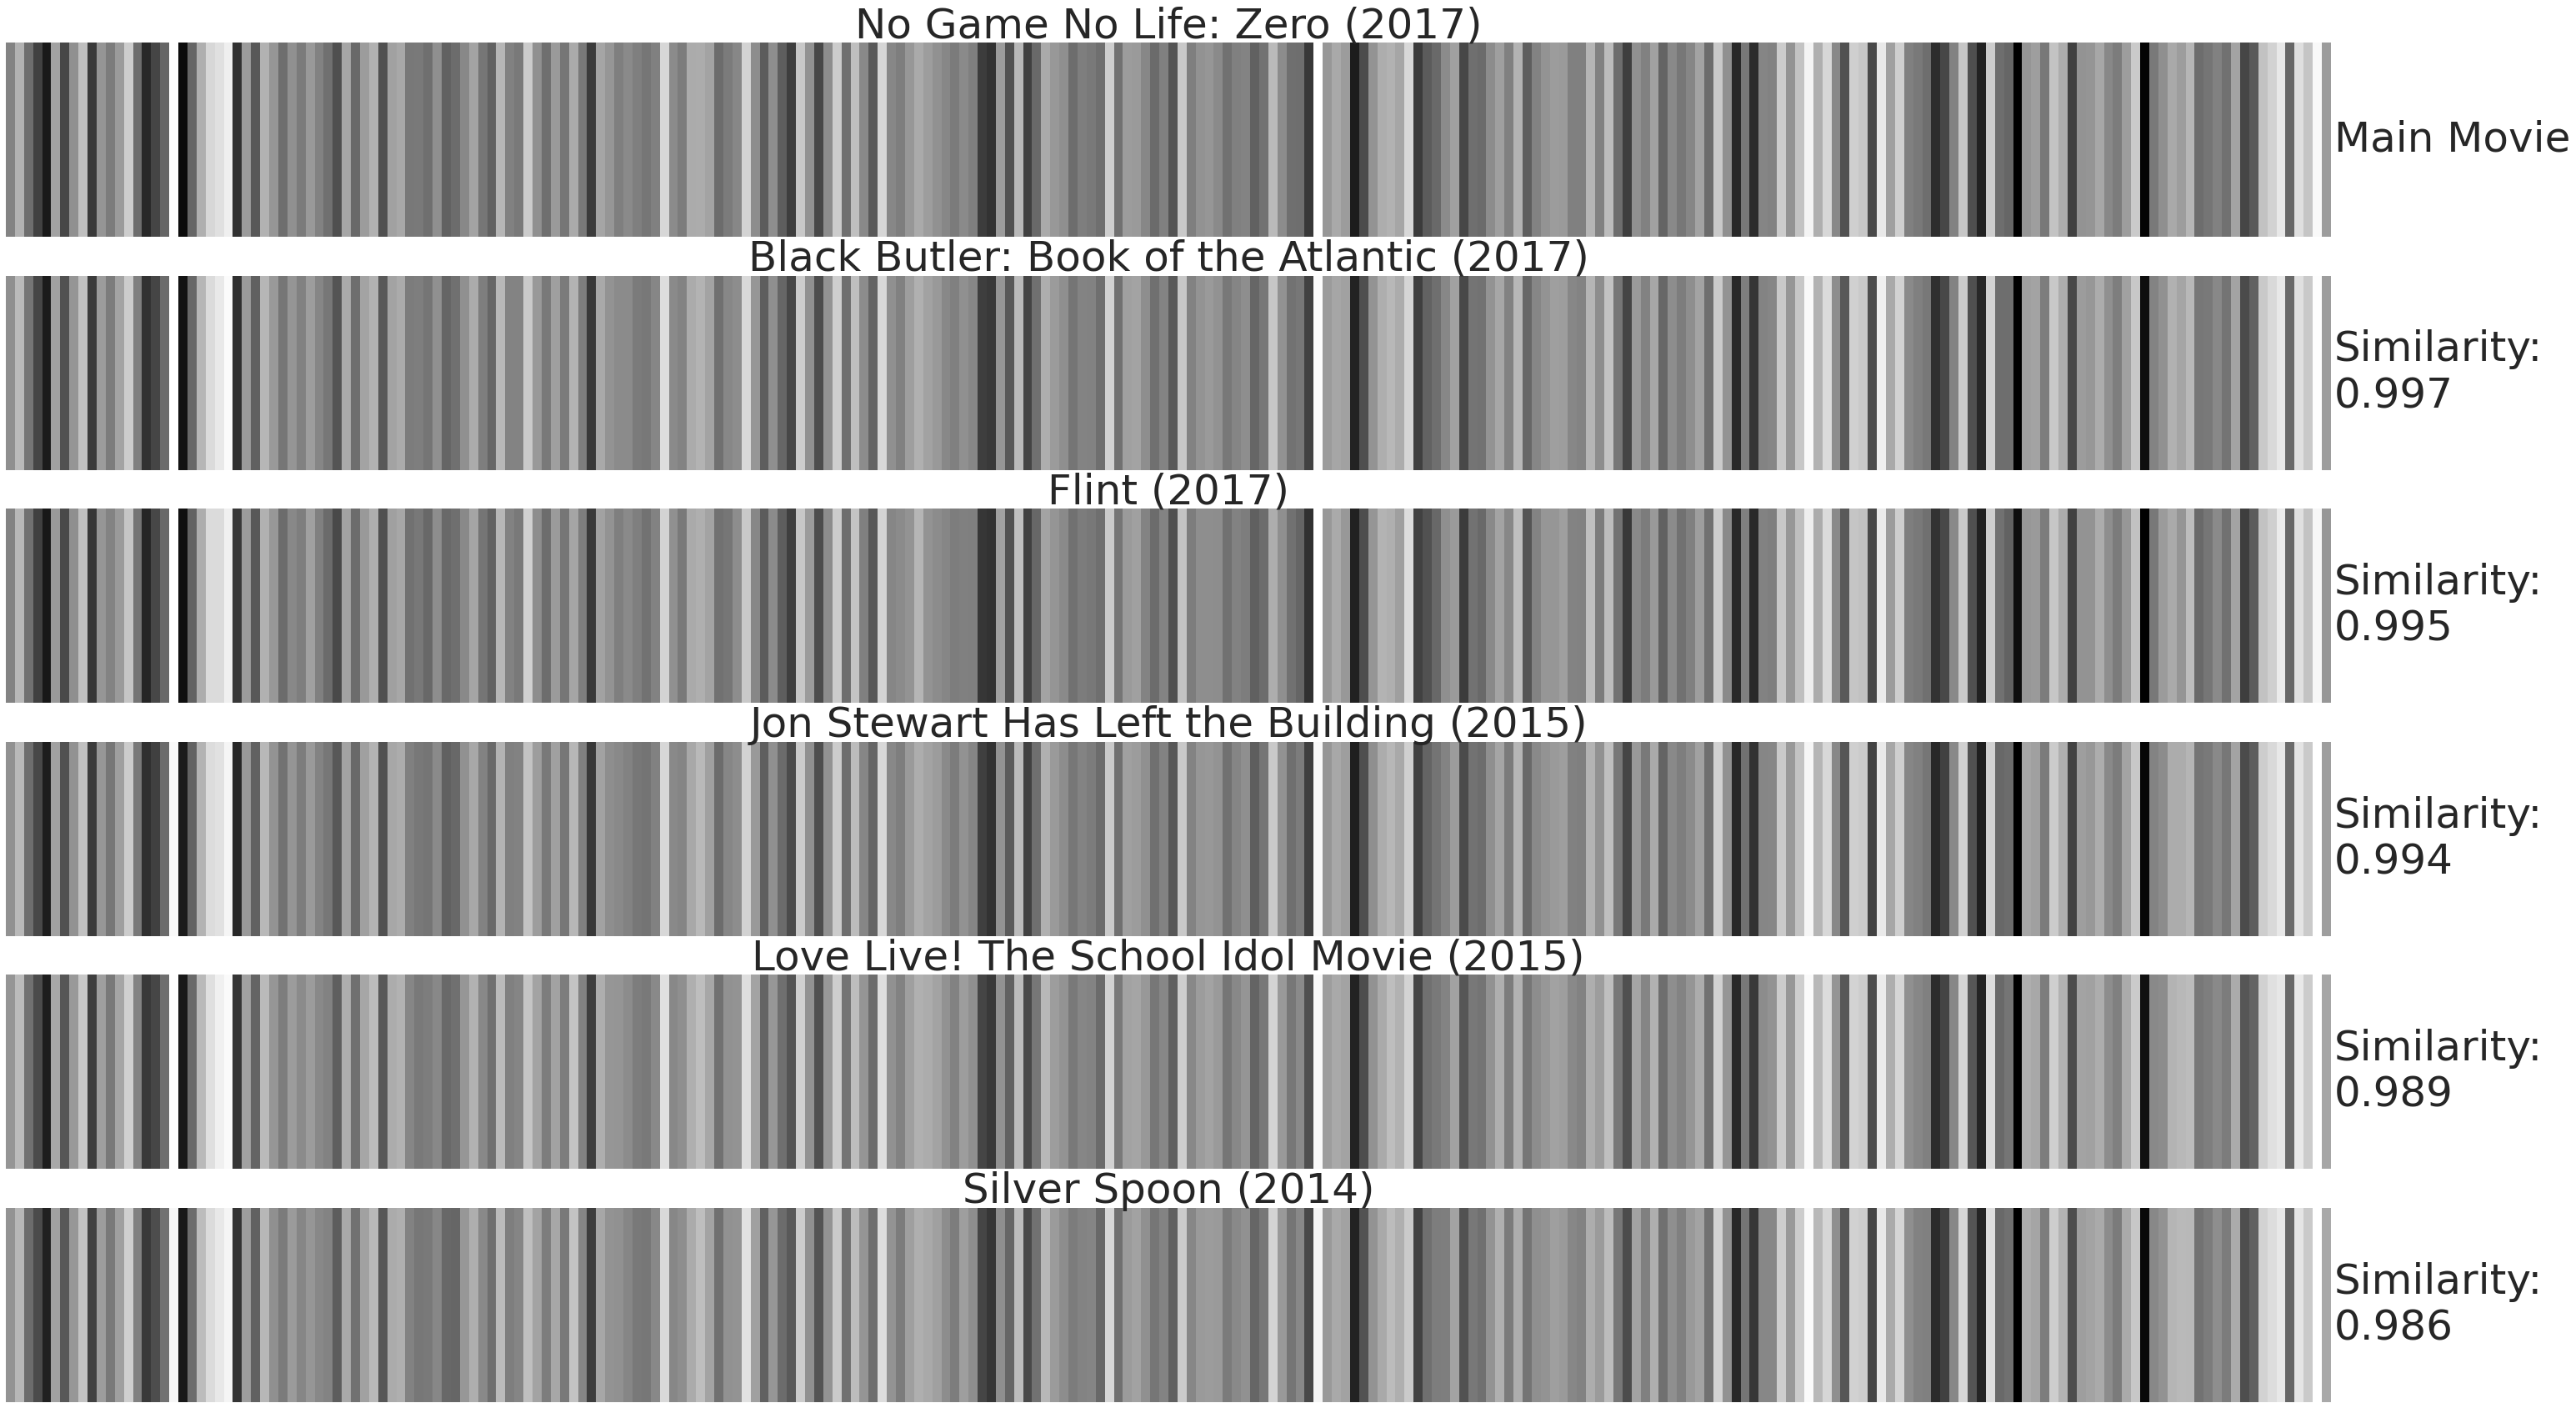

In [76]:
fig, axes = plt.subplots(6, 1, figsize = (50, 30))

slug = '193583'
mv_id_list = [(slug, "Main Movie"), *[t for t in model.wv.most_similar(slug)[:5]]] 

for ax, (mv_id, sim) in zip(axes.flat, mv_id_list):
    ax.imshow([model.wv[mv_id]], cmap = "binary", aspect = "auto")
    ax.set_title(data_mv.set_index('movieId').loc[int(mv_id), "title"], fontsize = 50)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Similarity:\n{sim:.3f}" if sim != mv_id_list[0][1] else sim,
                  rotation = "horizontal", ha = "left", va = "center", fontsize = 50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

The plot above shows five most similar movies to `movieId = '193583'` (No Game No Life: Zero (2019)). Up until now, the model can be used for recommending new movies using cosine similarity, but only based on one main movie.

# Generate Recommendation <a class='anchor' id='generate'></a>

We are finally ready with the embeddings for every movie that exists in `ratedls_train`. How these movie vectors are then used to suggest similar movies based on a certain movie list? One way is to calculate a **movie list vector** for each movie list by averaging together all the movie vectors in that movie list. These vectors then become the query to find similar movies based on cosine similarity. Here is an illustration using a users' rated movie list:

For each movie list in `ratedls_test`, calculate the average vectors using `meanVectors()` function. If the movie hasn't been embedded before, neglect the movie instead.

In [78]:
def meanVectors(mv_list):
    vec = []
    for mv_id in mv_list:
        try:
            vec.append(model.wv[mv_id])
        except KeyError:
            continue
    return np.mean(vec, axis=0)

For each movie list vector, recommend top $n$ similar movies based on the cosine similarity.

In [81]:
def similarMoviesByVector(vec, n = 10, by_name = True):
    # extract most similar movies for the input vector
    similar_movies = model.wv.similar_by_vector(vec, topn = n)
    
    # extract name and similarity score of the similar products
    if by_name:
        similar_movies = [(data_mv.loc[int(mv_id), "title"], sim)
                              for mv_id, sim in similar_movies]
    
    return similar_movies

## Show Recommendation for One User <a class='anchor' id='generate_example'></a>

et's test the movie embeddings to recommend top 10 movies for `ratedls_test` in for userId `82`.

In [103]:
def print_recommended_movies(userId, mv_list, n):
    print("============================")
    print("Movie List")
    print("============================")
    for mv_id in mv_list.set_index('userId').loc[int(userId)]['movie_ls']:
        print(data_mv.loc[int(mv_id), "title"])
    print()
    print("============================")
    print(f"TOP {n} RECOMMENDED MOVIES")
    print("============================")
    for movie, sim in similarMoviesByVector(meanVectors(mv_list.set_index('userId').loc[userId]['movie_ls']), n):
        print(f"[Similarity: {sim:.3f}] {movie}")
    print("============================")

In [104]:
print_recommended_movies(userId = 82, mv_list = ratedls_test, n = 10)

Movie List
Jumanji (1995)
Grumpier Old Men (1995)
Sabrina (1995)
American President, The (1995)
It Takes Two (1995)
Mighty Aphrodite (1995)
Steal Big, Steal Little (1995)
Jupiter's Wife (1994)
Judge Dredd (1995)
Mighty Morphin Power Rangers: The Movie (1995)
Party Girl (1995)
Showgirls (1995)
Something to Talk About (1995)
Total Eclipse (1995)
Babysitter, The (1995)
Dolores Claiborne (1995)
My Crazy Life (Mi vida loca) (1993)
Quiz Show (1994)
Underneath (1995)
Adventures of Priscilla, Queen of the Desert, The (1994)
I Like It Like That (1994)
True Lies (1994)
Low Down Dirty Shame, A (1994)
Age of Innocence, The (1993)
Airheads (1994)
Beverly Hills Cop III (1994)
Blown Away (1994)
Blue Chips (1994)
Body Snatchers (1993)
Color of Night (1994)
Killing Zoe (1994)
Perfect World, A (1993)
RoboCop 3 (1993)
Shadow, The (1994)
Terminal Velocity (1994)
Great White Hype, The (1996)
Last Dance (1996)
Cold Comfort Farm (1995)
Rock, The (1996)
Barb Wire (1996)
Chain Reaction (1996)
It's a Wonderful 

## Generate Recommendation for All Users <a class='anchor' id='generate_all'></a>

Let's generate 10 recommendation for all user. We must make sure that we're not give the rated item as the recommendation for user

In [128]:
def generate_recommendation(mv_ls, n_avail_mv, n_recommendation = 10):
    mean_vec = meanVectors(mv_ls)
    all_possible_rec = similarMoviesByVector(mean_vec,n = n_avail_mv, by_name=False)
    possible_rec = [(mv_id,score) for mv_id,score in all_possible_rec if str(mv_id) not in mv_ls]
    return possible_rec[:10]

ratedls_test['prediction'] = ratedls_test['movie_ls'].apply(lambda ls : generate_recommendation(ls,data_mv['movieId'].nunique(),10))

In [132]:
ratedls_test.head()

,userId,movie_ls,prediction
81,82,"[1, 2, 6, 10, 34, 47, 104, 110, 145, 153, 158,...","[(6332, 0.6020281314849854), (3988, 0.50497102..."
218,219,"[1, 2, 6, 10, 19, 21, 32, 44, 47, 50, 65, 95, ...","[(49130, 0.5477033257484436), (55854, 0.526558..."
55,56,"[10, 11, 19, 39, 47, 69, 110, 153, 160, 161, 1...","[(339, 0.6226528286933899), (247, 0.6134948730..."
598,599,"[1, 2, 3, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18,...","[(120919, 0.8023521900177002), (897, 0.7921096..."
264,265,"[25, 32, 36, 79, 110, 111, 150, 196, 230, 253,...","[(1372, 0.560987114906311), (1352, 0.501146793..."


In [163]:
results = ratedls_test.drop(['movie_ls'],axis=1).copy()
results = results.explode('prediction', ignore_index=True)
results['movieId'] = results['prediction'].str[0].astype(int)
results['prediction'] = results['prediction'].str[1].astype(float)

In [168]:
results.head(10)

,userId,prediction,movieId
0,82,0.602028,6332
1,82,0.504971,3988
2,82,0.504015,5620
3,82,0.481227,6535
4,82,0.476887,6402
5,82,0.476451,6619
6,82,0.473885,3990
7,82,0.473819,6410
8,82,0.472291,6424
9,82,0.464820,6427


In [170]:
results[results['userId'] == 83]

,userId,prediction,movieId
530,83,0.492626,66097
531,83,0.489892,71033
532,83,0.488987,74458
533,83,0.458987,69481
534,83,0.458252,39516
535,83,0.448915,68157
536,83,0.448295,73854
537,83,0.444530,69604
538,83,0.443989,4980
539,83,0.443169,69134


Now we have the results! We dont create the evaluation yet but sooner or later I will update the script. Bye!